In [1]:
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

The following set of functions takes the raw data extracted from the SQL tables and creates usable non-null feature columns. There's a little bit of cleaning, but this mostly involves creating dummies and filling nulls. For these nulls, I generally imputed the median (for continuous variables) or used the more frequent class (for binary variables).

In [11]:
def clean_flight_hours(x):
    invalids = [999.0, 9999.0, 99999.0, 999999.0]
    for n in invalids:
        if x==n:
            x = np.nan
    return x

def code_certs(cert):
    if cert=="BASC":
        return 1
    elif cert=="SPRT":
        return 2
    elif cert=="CL3 ":
        return 3
    elif cert=="CL2 ":
        return 4
    elif cert=="CL1 ":
        return 5
    else:
        return 0

def clean_and_gen_features(df):
    df.index = df.iloc[:, :2]
    df = df.drop(['ev_id', 'aircraft_key'], axis=1)
    
    crew_vars = pd.Index(['crew_no_2', 'crew_category_2', 'crew_age_2', 'med_certf_2',
                          'med_crtf_vldty_2', 'seatbelts_used_2', 'shldr_harn_used_2',
                          'crew_tox_perf_2', 'pc_profession_2', 'flight_hours_2'])
    old_cols = df.columns
    cols = old_cols[:-10].union(crew_vars, sort=False)
    df.columns = cols
    df['y'] = np.where(df['category_no']=='02', 0, 1)
    df = df[df['ev_type']=='ACC']
    df['airport_dist'] = df['apt_dist'].fillna(0)
    df['since_inspection'] = df['afm_hrs_last_insp'].fillna(df['afm_hrs_last_insp'].median())
    df['scnd_pilot'] = np.where(df['second_pilot']=="Y", 1, 0)
    df['personal_flight'] = np.where(df['type_fly']=="PERS", 1, 0)
    df['instructional_flight'] = np.where(df['type_fly']=="INST", 1, 0)
    df['cert_level'] = df['med_certf'].apply(code_certs)
    df['crew_age'] = np.where(df['crew_age']<15.0, 15.0, df['crew_age'])
    df['pilot_age'] = df['crew_age'].fillna(df['crew_age'].median())
    df['pro_pilot'] = np.where(df['pc_profession']=='Y   ', 1, 0)
    df['has_certs'] = np.where(df['certs_held']=="Y", 1, 0)
    df['total_seats'] = df['total_seats'].apply(lambda x: np.nan if x > 1000 else x)
    df['seats'] = df['total_seats'].fillna(df['total_seats'].median())
    df['flight_hours'] = df['flight_hours'].apply(clean_flight_hours)
    df['pilot_hours'] = df['flight_hours'].fillna(df['flight_hours'].median())
    df['flight_hours_2'] = df['flight_hours_2'].apply(clean_flight_hours)
    df['pilot_hours_2'] = df['flight_hours_2'].fillna(df['flight_hours'].median())
    df['vis_sm'] = df['vis_sm'].apply(lambda x: 10 if x > 10 else x)
    df['visibility'] = df['vis_sm'].fillna(10.0)
    df['instructional'] = np.where((df['crew_category']=="FLTI ") | (df['crew_category']=="DSTU "), 1, 0)
    df['instructional'] = np.where((df['crew_category_2']=="FLTI ") | (df['crew_category_2']=="DSTU "), 1, df['instructional'])
    df['wind_velocity'] = df['wind_vel_kts'].fillna(df['wind_vel_kts'].median())
    df['mid_air_acc'] = np.where((df['mid_air']=="Y"), 1, 0)
    df['is_plane'] = np.where(df['acft_category']=="AIR ", 1, 0)
    df['flight_plan'] = np.where((df['flt_plan_filed'].isna()) | (df['flt_plan_filed']=="NONE"), 0, 1)
    df['homebuilt_coded'] = np.where(df['homebuilt']=="Y  ", 1, 0)
    df['light_out'] = np.where(df['light_cond']=="DAYL", 0, 1)
    df['airframe_hours'] = df['afm_hrs'].fillna(df['afm_hrs'].median())
    df['gross_weight'] = df['cert_max_gr_wt'].fillna(df['cert_max_gr_wt'].median())
    return df

`adf_raw` is the aviation accident dataframe created in `extract_data.ipynb`.

In [12]:
adf = clean_and_gen_features(adf_raw)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Can't hurt to have a CSV backup.

In [13]:
adf.to_csv('adf_analysis.csv')

Let's see how our target column looks, and then create our X and y variables for modeling.

In [14]:
adf['y'].value_counts(dropna=False)

0    10845
1     2771
Name: y, dtype: int64

In [19]:
features = ['homebuilt_coded', 'light_out', 'airframe_hours', 'gross_weight',
            'visibility', 'wind_velocity', 'mid_air_acc', 'is_plane', 'instructional_flight',
            'personal_flight', 'pilot_hours', 'pro_pilot', 'pilot_age', 'cert_level',  
            'seats', 'scnd_pilot', 'since_inspection', 'airport_dist']
X = adf[features]
y = adf['y']

Define some 'dumb' models to serve as baselines for our scoring metrics. 

`informed_guess_model` knows that 20% of accidents are human error. 

`random_guess_model` guesses human error or not at random.

`always_zero` always chooses the majority class (human error). A good target to beat for overall accuracy, since this is unbalanced data.

In [15]:
def informed_guess_model(X):
    np.random.seed(123)
    length = X.shape[0]
    pred = np.zeros(length)
    cutoff = length // 5
    pred[:cutoff] = 1
    np.random.shuffle(pred)
    return pred

In [16]:
def random_guess_model(X):
    np.random.seed(123)
    length = X.shape[0]
    pred = np.zeros(length)
    cutoff = length // 2
    pred[:cutoff] = 1
    np.random.shuffle(pred)
    return pred

In [17]:
def always_zero_model(X):
    length = X.shape[0]
    pred = np.zeros(length)
    return pred

In [20]:
y_pred = random_guess_model(X)
print(accuracy_score(y, y_pred))
print(f1_score(y, y_pred))

0.49977967097532316
0.28896544524480633


In [22]:
y_pred = informed_guess_model(X)
print(accuracy_score(y, y_pred))
print(f1_score(y, y_pred))

0.6786133960047004
0.20349472151437933


In [23]:
y_pred = always_zero_model(X)
print(accuracy_score(y, y_pred))
print(f1_score(y, y_pred))

0.7964894242068156
0.0


/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Let's try out a bunch of classification models, using mostly default hyperparameters, and see how they do. At this point we're just trying to get a sense of what might work on this data.

In [96]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123)

In [72]:
def test_model(model):
    model.fit(X_train, y_train)
    model_name = str(model).split('(')[0]
    print(model_name, ":")
    print(confusion_matrix(y_test, model.predict(X_test)))
    print("Accuracy:", accuracy_score(y_test, model.predict(X_test)))
    print("F1 score", f1_score(y_test, model.predict(X_test)))
    print("")

In [59]:
knn = KNeighborsClassifier(n_neighbors=1)
test_model(knn)

KNeighborsClassifier :
[[2148  552]
 [ 540  164]]
Accuracy: 0.6792009400705052
F1 score 0.23098591549295774


In [60]:
knn10 = KNeighborsClassifier(n_neighbors=10)
test_model(knn10)

KNeighborsClassifier :
[[2671   29]
 [ 690   14]]
Accuracy: 0.7887779083431258
F1 score 0.03748326639892905


In [61]:
rfc = RandomForestClassifier(n_estimators=100, random_state=123)
test_model(rfc)

RandomForestClassifier :
[[2662   38]
 [ 686   18]]
Accuracy: 0.7873090481786134
F1 score 0.04736842105263159


In [62]:
gnb = GaussianNB()
test_model(gnb)

GaussianNB :
[[2608   92]
 [ 671   33]]
Accuracy: 0.7758519388954171
F1 score 0.07961399276236429


In [63]:
svc = SVC(gamma='scale')
test_model(svc)

SVC :
[[2691    9]
 [ 699    5]]
Accuracy: 0.7920094007050529
F1 score 0.013927576601671309


In [64]:
ada = AdaBoostClassifier()
ada.fit(X_train, y_train)
test_model(ada)

AdaBoostClassifier :
[[2683   17]
 [ 695    9]]
Accuracy: 0.790834312573443
F1 score 0.024657534246575345


In [97]:
lr = LogisticRegression(solver="lbfgs", max_iter=5000)
lr.fit(X_train, y_train)
test_model(lr)

LogisticRegression :
[[2692    8]
 [ 698    6]]
Accuracy: 0.7925969447708578
F1 score 0.01671309192200557



It looks like most models have an issue with recall - they classify too many cases in the majority group. Oversampling our minority class should help with this.

In [76]:
smote_scale = 0.75

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123)
smote = SMOTE(random_state=0, sampling_strategy=smote_scale)
X_train, y_train = smote.fit_sample(X_train, y_train)

Let's run through our model zoo again with the oversampled data.

In [77]:
for model in [knn, knn10, rfc, gnb, svc, ada, lr]:
    test_model(model)

KNeighborsClassifier :
[[1954  746]
 [ 494  210]]
Accuracy: 0.63572267920094
F1 score 0.2530120481927711

KNeighborsClassifier :
[[1991  709]
 [ 496  208]]
Accuracy: 0.6460047003525264
F1 score 0.256631708821715

RandomForestClassifier :
[[2595  105]
 [ 662   42]]
Accuracy: 0.7746768507638073
F1 score 0.09870740305522913

GaussianNB :
[[2603   97]
 [ 670   34]]
Accuracy: 0.7746768507638073
F1 score 0.081437125748503

SVC :
[[2573  127]
 [ 661   43]]
Accuracy: 0.7685076380728555
F1 score 0.09839816933638444

AdaBoostClassifier :
[[2529  171]
 [ 642   62]]
Accuracy: 0.7611633372502937
F1 score 0.13233724653148346

LogisticRegression :
[[2501  199]
 [ 622   82]]
Accuracy: 0.7588131609870741
F1 score 0.166497461928934



Logistic Regression looks good - high F1 score with decent accuracy, plus all the advantages of LR (fast, interpretable, probability predictions).

Let's try to find an optimal oversampling strategy (minority/majority class ratio) by running a bunch of logistic regressions and graphing the accuracy and F1 scores.

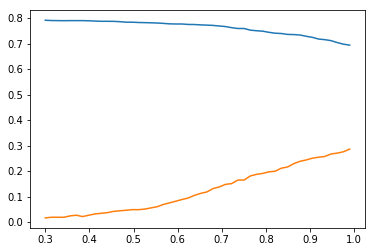

In [80]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123)
accs = []
f1s = []
lr = LogisticRegression(solver="lbfgs", max_iter = 5000)
for strat in np.linspace(0.3, 0.99, 50):
    smote = SMOTE(random_state=0, sampling_strategy=strat)
    X_resample, y_resample = smote.fit_sample(X_train, y_train)
    lr.fit(X_resample, y_resample)
    y_pred = lr.predict(X_test)
    accs.append(accuracy_score(y_test, y_pred))
    f1s.append(f1_score(y_test, y_pred))
    
plt.plot(np.linspace(0.3, 0.99, 50), accs)
plt.plot(np.linspace(0.3, 0.99, 50), f1s)

It looks like 0.9 is a pretty good tradeoff.

In [108]:
smote_scale = 0.9

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123)
smote = SMOTE(random_state=0, sampling_strategy=smote_scale)
X_train, y_train = smote.fit_sample(X_train, y_train)

test_model(lr)

LogisticRegression :
[[2321  379]
 [ 552  152]]
Accuracy: 0.7264982373678026
F1 score 0.24615384615384614



What if we try using something other than 0.5 for the decision threshold?

Best accuracy is 0.7931844888366627
Best F1 score is 0.35084175084175084


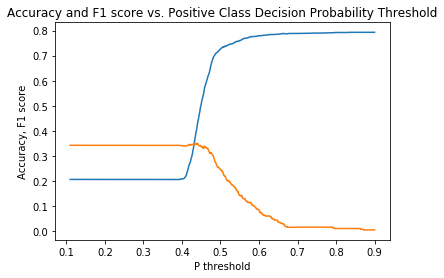

In [117]:
thresh_ps = np.linspace(.11,.9,1000)
model_val_probs = lr.predict_proba(X_test)[:,1] 

acc_scores = []
f1_scores = []
for p in thresh_ps:
    model_val_labels = model_val_probs >= p
    acc_scores.append(accuracy_score(y_test, model_val_labels))
    f1_scores.append(f1_score(y_test, model_val_labels))
    
plt.plot(thresh_ps, acc_scores)
plt.plot(thresh_ps, f1_scores)
plt.title('Accuracy and F1 score vs. Positive Class Decision Probability Threshold')
plt.xlabel('P threshold')
plt.ylabel('Accuracy, F1 score')

best_acc_score = np.max(acc_scores)
best_f1_score = np.max(f1_scores) 
best_thresh_p = thresh_ps[np.argmax(f1_scores)]

print(f'Best accuracy is {best_acc_score}')
print(f'Best F1 score is {best_f1_score}')

Seems like we're best off sticking with 0.5. 

This model isn't fantastic - in particular, it is somewhat less accurate than just predicting 0 every time. Luckily, we have NTSB investigators and don't need to predict the cause of plane accidents using a handful of messy and sometimes missing variables.

Let's now train a LR model on our entire dataset for use in the Flask app.

In [163]:
smote = SMOTE(random_state=0, sampling_strategy=0.90)
X_smote, y_smote = smote.fit_sample(X, y)
lr_all = LogisticRegression(solver="lbfgs", max_iter=5000)
lr_all.fit(X_smote, y_smote)
print(confusion_matrix(y, lr_all.predict(X)))
print("Accuracy:", accuracy_score(y, lr_all.predict(X)))
print("F1 score", f1_score(y, lr_all.predict(X)))

[[9243 1602]
 [2115  656]]
Accuracy: 0.7270123384253819
F1 score 0.2608868562338437


What do our actual coefficients look like?

Three of the dummy variables have fairly strong coefficients. Aircraft that are home-built seem much more likely to be in non-pilot-error accidents, which makes sense. And mid-air accidents and instructional flights are more likely to be caused by human error - also fairly logical.

In [166]:
coefs = lr_all.coef_[0]
pd.DataFrame(zip(features, np.exp(coefs))).sort_values(1, ascending=False)

,0,1
0,homebuilt_coded,1.534540
15,scnd_pilot,1.197545
11,pro_pilot,1.146412
7,is_plane,1.104862
4,visibility,1.052750
14,seats,1.003513
10,pilot_hours,1.000029
16,since_inspection,1.000026
2,airframe_hours,1.000001
3,gross_weight,1.000000


We need our LR model and our dataset for the Flask app, so let's pickle them both.

In [167]:
import pickle

with open('./lr.pkl', 'wb') as f:
    pickle.dump(lr_all, f)
    
with open('./adf.pkl', 'wb') as f:
    pickle.dump(adf, f)